In [1]:
# üìå 1. Importar Librer√≠as
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [2]:
# üìå 2. Cargar Municipios y Convertir a WGS 84
municipios_gdf = gpd.read_file("municipios.shp")
municipios_gdf = municipios_gdf.to_crs(epsg=4326)  # Asegurar CRS correcto

In [3]:
# üìå 3. Cargar Datos de Poblaci√≥n y Unir con Municipios
poblacion_df = pd.read_csv("poblacion.csv")
municipios_gdf = municipios_gdf.merge(poblacion_df, left_on="nombre", right_on="municipio", how="left")

In [4]:
# üìå 4. Clasificaci√≥n de Municipios por Tama√±o Poblacional
def clasificar_municipio(poblacion):
    if poblacion < 10000:
        return "peque√±o"
    elif 10000 <= poblacion < 50000:
        return "mediano"
    else:
        return "grande"

municipios_gdf["categoria"] = municipios_gdf["poblacion"].apply(clasificar_municipio)

In [5]:
# üìå 5. Asignaci√≥n de Tiempos de Viaje  seg√∫n el tama√±o del municipio y el tipo de servicio cultural: museos y bibliotecas.

tiempos_viaje = {
    "peque√±o": {"bibliotecas": 10, "museos": 15},
    "mediano": {"bibliotecas": 15, "museos": 20},
    "grande": {"bibliotecas": 20, "museos": 25}
}

def asignar_tiempo_viaje(row, tipo):
    return tiempos_viaje[row["categoria"]][tipo]

municipios_gdf["tiempo_bibliotecas"] = municipios_gdf.apply(lambda row: asignar_tiempo_viaje(row, "bibliotecas"), axis=1)
municipios_gdf["tiempo_museos"] = municipios_gdf.apply(lambda row: asignar_tiempo_viaje(row, "museos"), axis=1)

In [6]:
# üìå 6. C√°lculo de Centroides de los NUCLEOS URBANOS (Transformaci√≥n Correcta de CRS)
# üìå Cargar N√∫cleos de Poblaci√≥n y Convertir a WGS 84
nucleos_gdf = gpd.read_file("nucleos.shp").to_crs(epsg=4326)  # Asegurar CRS correcto

# üìå Convertir a CRS proyectado (metros) para c√°lculo de centroides
nucleos_proj = nucleos_gdf.to_crs(epsg=3857)

# üìå Calcular centroides
nucleos_proj["centroide"] = nucleos_proj.geometry.centroid

# üìå Volver a WGS 84 con los centroides
nucleos_proj = nucleos_proj.set_geometry("centroide").to_crs(epsg=4326)

# üìå Crear el GeoDataFrame de centroides basado en los n√∫cleos urbanos
centroides_gdf = gpd.GeoDataFrame(
    nucleos_proj[["nombre", "centroide"]],
    geometry="centroide",
    crs="EPSG:4326"
)

# üìå Verificar la estructura
print(centroides_gdf.head())


                       nombre                 centroide
0                     Sevilla  POINT (-5.95927 37.3897)
1                       Camas  POINT (-6.03425 37.3999)
2  Valencina de la Concepci√≥n  POINT (-6.0754 37.41508)


In [7]:
# üìå 7. Cargar Equipamientos Culturales (Bibliotecas y Museos) y Asegurar WGS 84
bibliotecas_gdf = gpd.read_file("bibliotecas.shp").to_crs(epsg=4326)
museos_gdf = gpd.read_file("museos.shp").to_crs(epsg=4326)

In [8]:
# üìå 8. Filtrar Equipamientos que Est√°n Dentro de los Municipios
bibliotecas_gdf = bibliotecas_gdf[bibliotecas_gdf.geometry.apply(lambda x: any(x.within(m) for m in municipios_gdf.geometry))]
museos_gdf = museos_gdf[museos_gdf.geometry.apply(lambda x: any(x.within(m) for m in municipios_gdf.geometry))]

In [9]:
# üìå 9. Generar Is√≥cronas con OpenRouteService
import requests

# üìå Tu clave de API de OpenRouteService
API_KEY = "5b3ce3597851110001cf62488feab9edfc2445428dc5cfaf247a6357"

def obtener_isocrona(lat, lon, tiempo):
    url = "https://api.openrouteservice.org/v2/isochrones/foot-walking"
    headers = {"Authorization": API_KEY}  # üîπ Clave en headers
    params = {
        "locations": [[lon, lat]],  # Longitud primero, luego latitud
        "range": [tiempo * 60],  # Tiempo en segundos
        "range_type": "time",
        "units": "m"
    }
    
    response = requests.post(url, headers=headers, json=params)  # üîπ A√±adimos headers
    
    if response.status_code == 200:
        data = response.json()
        return data["features"][0]["geometry"]  # Extraer la geometr√≠a
    else:
        print("Error:", response.json())  # Mostrar error exacto
        return None


In [10]:
# üìå 1Ô∏è‚É£ Verificar que centroides_gdf ya existe y tiene los centroides
print("Columnas antes del merge:", centroides_gdf.columns)

# üìå 2Ô∏è‚É£ Eliminar columnas duplicadas antes del merge (por si acaso)
columnas_a_eliminar = ["tiempo_bibliotecas", "tiempo_museos"]
centroides_gdf = centroides_gdf.drop(columns=[col for col in columnas_a_eliminar if col in centroides_gdf.columns], errors="ignore")

# üìå 3Ô∏è‚É£ Hacer el merge con municipios_gdf para traer los tiempos de viaje
centroides_gdf = centroides_gdf.merge(
    municipios_gdf[["nombre", "tiempo_bibliotecas", "tiempo_museos"]],
    on="nombre",
    how="left"
)

# üìå 4Ô∏è‚É£ Verificar si las columnas se a√±adieron correctamente
print(centroides_gdf[["nombre", "tiempo_bibliotecas", "tiempo_museos"]].head())

Columnas antes del merge: Index(['nombre', 'centroide'], dtype='object')
                       nombre  tiempo_bibliotecas  tiempo_museos
0                     Sevilla                  20             25
1                       Camas                  15             20
2  Valencina de la Concepci√≥n                  10             15


In [11]:
# üìå PROBANDO CON UN MUNICIPIO (Sevilla)
# üìå Asegurarse de que el centroide de Sevilla se seleccione correctamente
sevilla_fila = centroides_gdf[centroides_gdf["nombre"] == "Sevilla"]

if not sevilla_fila.empty:
    sevilla_centroide = sevilla_fila["centroide"].values[0]
    lat, lon = sevilla_centroide.y, sevilla_centroide.x
    tiempo = int(sevilla_fila["tiempo_bibliotecas"].values[0])  # Convertimos a int

    print(f"Centroide correcto para Sevilla: {lon}, {lat}") 

    # üìå Llamar a la API con el centroide correcto
    print(f"Probando is√≥crona para Sevilla con {tiempo} min...")
    isocrona = obtener_isocrona(lat, lon, tiempo)

    # üìå Verificar las primeras coordenadas de la is√≥crona
    print("Primeras coordenadas de la is√≥crona:", isocrona["coordinates"][0][:5])
else:
    print("‚ö†Ô∏è Error: No se encontr√≥ Sevilla en el DataFrame centroides_gdf.")


Centroide correcto para Sevilla: -5.959268435873464, 37.389704581484736
Probando is√≥crona para Sevilla con 20 min...
Primeras coordenadas de la is√≥crona: [[-5.976754, 37.386933], [-5.975399, 37.385264], [-5.974188, 37.384071], [-5.971851, 37.382332], [-5.969715, 37.380518]]


In [12]:
# üìå Obtener coordenadas del centroide de Sevilla
lat, lon = centroides_gdf.loc[0, "centroide"].y, centroides_gdf.loc[0, "centroide"].x

# üìå Obtener los tiempos de viaje para bibliotecas y museos
tiempo_bibliotecas = int(centroides_gdf.loc[0, "tiempo_bibliotecas"])
tiempo_museos = int(centroides_gdf.loc[0, "tiempo_museos"])

# üìå Elegir el tiempo m√°ximo entre bibliotecas y museos
tiempo_maximo = max(tiempo_bibliotecas, tiempo_museos)

# üìå Verificaci√≥n antes de ejecutar la is√≥crona
print(f"üîπ Municipio: {centroides_gdf.loc[0, 'nombre']}")
print(f"   - Tiempo bibliotecas: {tiempo_bibliotecas} minutos")
print(f"   - Tiempo museos: {tiempo_museos} minutos")
print(f"   - Tiempo m√°ximo utilizado: {tiempo_maximo} minutos")

# üìå Obtener la is√≥crona con el tiempo m√°ximo
isocrona = obtener_isocrona(lat, lon, tiempo_maximo)

# üìå Verificar salida de la is√≥crona
print("Is√≥crona generada:", isocrona)

üîπ Municipio: Sevilla
   - Tiempo bibliotecas: 20 minutos
   - Tiempo museos: 25 minutos
   - Tiempo m√°ximo utilizado: 25 minutos
Is√≥crona generada: {'coordinates': [[[-5.981436, 37.388034], [-5.979964, 37.384956], [-5.979562, 37.384245], [-5.976235, 37.381588], [-5.972416, 37.378066], [-5.971791, 37.377373], [-5.971494, 37.377044], [-5.968934, 37.374417], [-5.966734, 37.372062], [-5.966066, 37.3716], [-5.964821, 37.370864], [-5.962362, 37.370933], [-5.959615, 37.371263], [-5.954971, 37.371641], [-5.954912, 37.371676], [-5.953078, 37.373541], [-5.949494, 37.374656], [-5.948561, 37.375221], [-5.948016, 37.375808], [-5.946125, 37.378044], [-5.94118, 37.380951], [-5.940644, 37.384343], [-5.941518, 37.385762], [-5.94028, 37.390719], [-5.939746, 37.391764], [-5.939511, 37.39274], [-5.939375, 37.395853], [-5.940919, 37.400934], [-5.940859, 37.40246], [-5.940868, 37.402535], [-5.941057, 37.403102], [-5.941582, 37.403626], [-5.941672, 37.403664], [-5.943121, 37.403972], [-5.94731, 37.40400

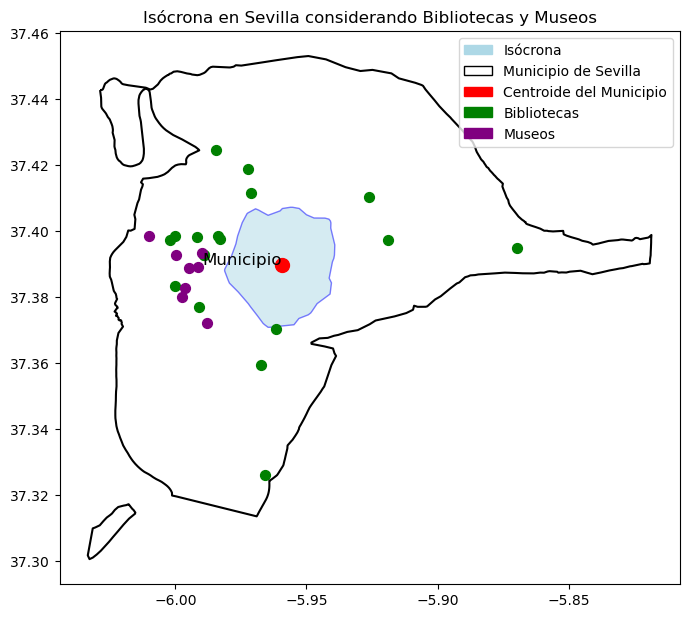

In [13]:
# üìå PROBANDO CON UN MUNICIPIO (Sevilla)
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
import matplotlib.patches as mpatches

# üìå Convertir la is√≥crona en un objeto geom√©trico
isocrona_geom = shape(isocrona)  # Convierte el JSON en una geometr√≠a de Shapely

# üìå Crear un GeoDataFrame con la is√≥crona
isocrona_gdf = gpd.GeoDataFrame(geometry=[isocrona_geom], crs="EPSG:4326")

# üìå Obtener la capa del municipio de Sevilla
municipio_sevilla = municipios_gdf[municipios_gdf["nombre"] == "Sevilla"]

# üìå Obtener el centroide del municipio de Sevilla
centroide_sevilla = centroides_gdf.loc[centroides_gdf["nombre"] == "Sevilla", "centroide"].values[0]

# üìå Obtener las bibliotecas y museos en Sevilla
bibliotecas_sevilla = bibliotecas_gdf[bibliotecas_gdf["municipio"] == "Sevilla"]
museos_sevilla = museos_gdf[museos_gdf["municipio"] == "Sevilla"]

# üìå Crear un GeoDataFrame con el centroide
punto_municipio = gpd.GeoDataFrame({"nombre": ["Municipio de Sevilla"]}, geometry=[centroide_sevilla], crs="EPSG:4326")

# üìå Graficar todas las capas
fig, ax = plt.subplots(figsize=(8, 8))

# üìå Graficar el municipio de Sevilla
municipio_sevilla.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1.5)

# üìå Graficar la is√≥crona
isocrona_gdf.plot(ax=ax, color="lightblue", edgecolor="blue", alpha=0.5)

# üìå Graficar los puntos
punto_municipio.plot(ax=ax, color="red", markersize=100)
bibliotecas_sevilla.plot(ax=ax, color="green", markersize=50)
museos_sevilla.plot(ax=ax, color="purple", markersize=50)

# üìå Etiqueta del centroide del municipio
ax.text(centroide_sevilla.x, centroide_sevilla.y, "Municipio", fontsize=12, ha="right", color="black")

# üìå Crear leyenda manualmente
legend_patches = [
    mpatches.Patch(color="lightblue", label="Is√≥crona"),
    mpatches.Patch(edgecolor="black", facecolor="none", label="Municipio de Sevilla"),
    mpatches.Patch(color="red", label="Centroide del Municipio"),
    mpatches.Patch(color="green", label="Bibliotecas"),
    mpatches.Patch(color="purple", label="Museos")
]

plt.legend(handles=legend_patches, loc="upper right")

# üìå Mostrar el mapa
plt.title("Is√≥crona en Sevilla considerando Bibliotecas y Museos")
plt.show()

Generando is√≥crona para Sevilla con tiempo m√°ximo de 25 minutos...
Generando is√≥crona para Camas con tiempo m√°ximo de 20 minutos...
Generando is√≥crona para Valencina de la Concepci√≥n con tiempo m√°ximo de 15 minutos...


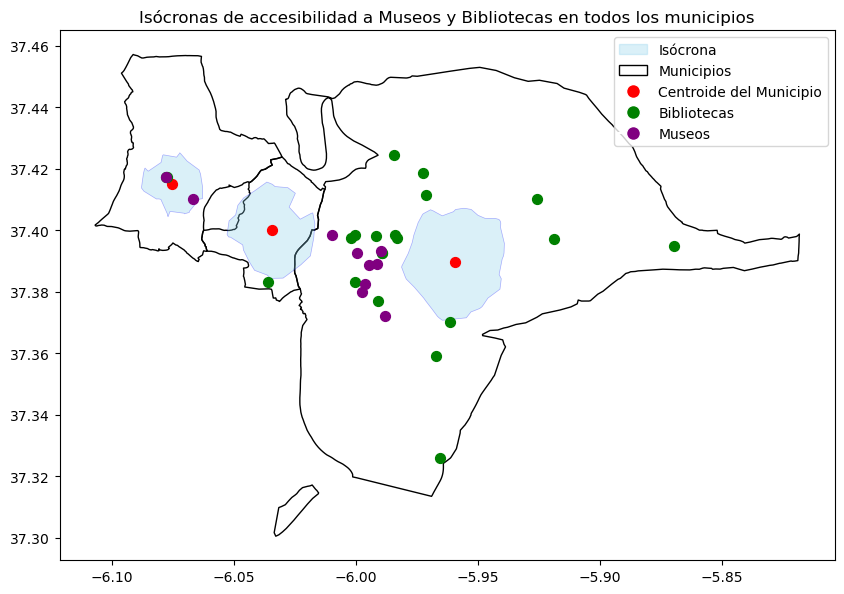

In [14]:
# üìå Importar librer√≠as
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from shapely.geometry import Polygon

# üìå Crear la figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# üìå Dibujar el contorno de todos los municipios
municipios_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)

# üìå Crear listas para la leyenda personalizada
handles = [
    mpatches.Patch(color="skyblue", alpha=0.3, label="Is√≥crona"),
    mpatches.Patch(edgecolor="black", facecolor="none", linewidth=1, label="Municipios"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Centroide del Municipio"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Bibliotecas"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="purple", markersize=10, label="Museos"),
]

# üìå Lista para almacenar todas las is√≥cronas
isocronas_list = []

# üìå Recorrer todos los municipios y calcular su is√≥crona
for i, row in centroides_gdf.iterrows():
    lat, lon = row["centroide"].y, row["centroide"].x
    tiempo_bibliotecas = int(row["tiempo_bibliotecas"])
    tiempo_museos = int(row["tiempo_museos"])
    
    # üìå Obtener el tiempo m√°ximo de viaje
    tiempo_maximo = max(tiempo_bibliotecas, tiempo_museos)

    print(f"Generando is√≥crona para {row['nombre']} con tiempo m√°ximo de {tiempo_maximo} minutos...")
    
    # üìå Obtener la is√≥crona
    isocrona = obtener_isocrona(lat, lon, tiempo_maximo)
    
    # üìå Verificar si la API devolvi√≥ una is√≥crona v√°lida
    if isocrona and "coordinates" in isocrona:
        # üìå Convertir la is√≥crona en un GeoDataFrame
        polygon = Polygon(isocrona["coordinates"][0])  # Tomamos el primer pol√≠gono
        isocrona_gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
        
        # üìå Verificar si la conversi√≥n fue correcta
        if not isocrona_gdf.empty:
            isocrona_gdf.plot(ax=ax, facecolor="skyblue", alpha=0.3, edgecolor="blue", linewidth=0.5)
            isocronas_list.append(isocrona_gdf)  # üìå Almacenar la is√≥crona en la lista
        else:
            print(f"‚ö†Ô∏è Advertencia: No se pudo convertir la is√≥crona en un GeoDataFrame para {row['nombre']}.")
    else:
        print(f"‚ö†Ô∏è Advertencia: La API no devolvi√≥ una is√≥crona v√°lida para {row['nombre']}.")

    # üìå Dibujar el centroide del municipio
    ax.scatter(lon, lat, color="red", s=50)

# üìå Unir todas las is√≥cronas en un √∫nico GeoDataFrame
if isocronas_list:
    isocronas_gdf = gpd.GeoDataFrame(pd.concat(isocronas_list, ignore_index=True), crs="EPSG:4326")
else:
    isocronas_gdf = gpd.GeoDataFrame(columns=["geometry"], crs="EPSG:4326")  # Evitar errores si est√° vac√≠o

# üìå Dibujar bibliotecas y museos
bibliotecas_gdf.plot(ax=ax, marker="o", color="green", linestyle="None", markersize=50)
museos_gdf.plot(ax=ax, marker="o", color="purple", linestyle="None", markersize=50)

# üìå Configurar t√≠tulo y leyenda
plt.title("Is√≥cronas de accesibilidad a Museos y Bibliotecas en todos los municipios")
ax.legend(handles=handles, loc="upper right")

plt.show()


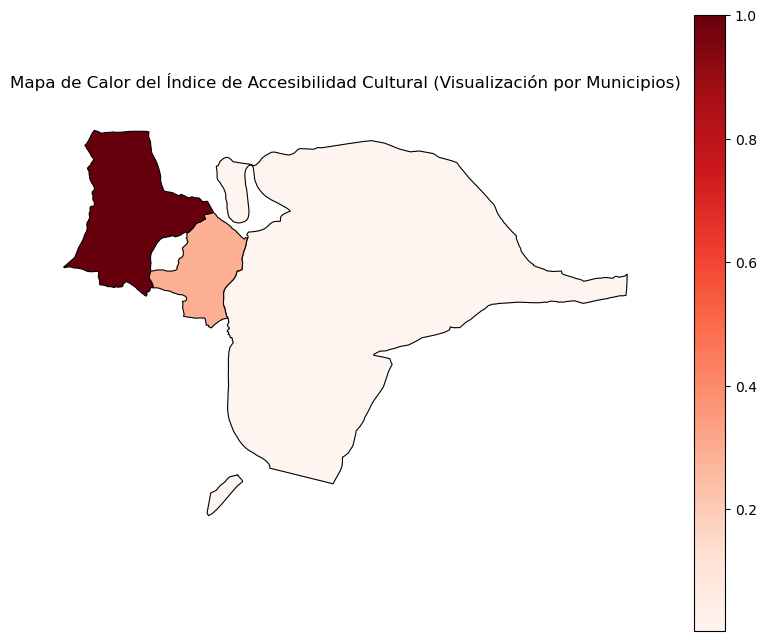

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# üìå Asegurar que todo est√° en un CRS proyectado para c√°lculos de √°rea correctos
nucleos_gdf = nucleos_gdf.to_crs(epsg=3857)
municipios_gdf = municipios_gdf.to_crs(epsg=3857)
isocronas_gdf = isocronas_gdf.to_crs(epsg=3857)

# üìå Verificar que la columna 'poblacion' est√° en municipios_gdf
if "poblacion" not in municipios_gdf.columns:
    raise ValueError("La columna 'poblacion' no se encuentra en municipios_gdf.")

# üìå Si ya existe la columna 'poblacion' en nucleos_gdf, eliminarla antes del merge
if "poblacion" in nucleos_gdf.columns:
    nucleos_gdf = nucleos_gdf.drop(columns=["poblacion"])

# üìå Unir la poblaci√≥n de municipios_gdf a nucleos_gdf seg√∫n el nombre del municipio
nucleos_gdf = nucleos_gdf.merge(municipios_gdf[["nombre", "poblacion"]], on="nombre", how="left")

# üìå Asegurar que la columna 'poblacion' ahora est√° en nucleos_gdf sin problemas
if "poblacion" not in nucleos_gdf.columns:
    raise ValueError("No se logr√≥ unir la poblaci√≥n a nucleos_gdf.")

# üìå Reemplazar valores NaN en 'poblacion' para evitar errores de divisi√≥n
nucleos_gdf["poblacion"] = nucleos_gdf["poblacion"].fillna(1)  # Evitar NaN
nucleos_gdf.loc[nucleos_gdf["poblacion"] == 0, "poblacion"] = 1  # Evitar divisiones por 0

# üìå Calcular el √°rea total de cada n√∫cleo poblacional
nucleos_gdf["area_nucleo"] = nucleos_gdf.geometry.area

# üìå Calcular el √°rea de la is√≥crona dentro de cada n√∫cleo
nucleos_gdf["area_isocrona"] = nucleos_gdf.apply(
    lambda row: isocronas_gdf.geometry.intersection(row.geometry).area.sum(), axis=1
)

# üìå Calcular el √çndice de Accesibilidad ponderado por poblaci√≥n
nucleos_gdf["indice_accesibilidad"] = (nucleos_gdf["area_isocrona"] / nucleos_gdf["area_nucleo"]) / nucleos_gdf["poblacion"]

# üìå Normalizar el √≠ndice (valores entre 0 y 1)
nucleos_gdf["indice_accesibilidad"] = nucleos_gdf["indice_accesibilidad"] / nucleos_gdf["indice_accesibilidad"].max()

# üìå Asignar el √≠ndice de accesibilidad del n√∫cleo a su municipio correspondiente
municipios_gdf = municipios_gdf.merge(nucleos_gdf[["nombre", "indice_accesibilidad"]], on="nombre", how="left")

# üìå Crear el heatmap del √çndice de Accesibilidad en municipios
fig, ax = plt.subplots(figsize=(10, 8))

# üìå Dibujar municipios coloreados seg√∫n accesibilidad
municipios_gdf.plot(column="indice_accesibilidad", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# üìå Agregar t√≠tulo y ocultar ejes
plt.title("Mapa de Calor del √çndice de Accesibilidad Cultural (Visualizaci√≥n por Municipios)")
plt.axis("off")

plt.show()


In [16]:
import pandas as pd
from tabulate import tabulate

# üìå Crear DataFrame con valores est√©ticos
tabla_df = municipios_gdf[["nombre", "indice_accesibilidad"]].sort_values(by="indice_accesibilidad", ascending=False)

# üìå Convertir valores a formato m√°s legible
tabla_df["indice_accesibilidad"] = tabla_df["indice_accesibilidad"].apply(lambda x: f"{x:.3f}")

# üìå Mostrar la tabla formateada
print(tabulate(tabla_df, headers="keys", tablefmt="fancy_grid", showindex=False))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ nombre                     ‚îÇ   indice_accesibilidad ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Valencina de la Concepci√≥n ‚îÇ                  1     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Camas                      ‚îÇ                  0.288 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Sevilla                    ‚îÇ                  0.003 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê